Laboratorio Computacional N°3: Biot-Savart

Grupo 14

$$\vec{B}(\vec{r}) =  \frac{\mu_0 I}{4 \pi} \int_C \frac{d\vec{l} \times (\vec{r}-\vec{l})}{|\vec{r}-\vec{l}|^3}$$

Como punto de partida tomamos el código de *Mr. P. Solver*, explicado en el video [*Biot Savart Law in Python: Any wire you want, no paper required*](https://www.youtube.com/watch?v=srk2YZKMn-E&t=538s). En este código, se aplica Biot-Savart directamente, sin cálculos intermedios. Esto es, a partir de una línea parametrizada y con la ayuda de la librería SymPy, se obtienen los vectores intermedios $\vec{r}$, $\vec{l}$, $\vec{dl}$, se obtiene el producto vectorial de la integral, y se integra directamente.

Introducimos varias mejoras:
- La posibilidad de trabajar con cualquier línea parametrizada y con más de una.
- Las líneas parametrizadas sólo deben definirse una vez (en el código original está separada la definición para graficarla y para calcular el campo magnético aplicando Biot-Savart)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, quad_vec
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'colab'
from IPython.display import HTML
import sympy as smp
from sympy.vector import cross

Definición de símbolos para la biblioteca SymPy

In [ ]:
t, x, y, z = smp.symbols('t, x, y, z')
mu0 = 4*np.pi #En su forma original 4pi*10^-7 provoca problemas con el renderizado de los vectores

Este programa funciona definiendo líneas parametrizadas en una colección *l*, a partir de una variable t, tal que 0 <= t<= 1

También se define una colección de valores de corriente I, donde por ejemplo el primer elemento corresponde al valor de la corriente para la línea en el primer elemento de l

A partir de la experiencia: Un valor positivo de corriente, en términos de una espira circular, implica que la corriente circula en sentido anti-horario. Un valor negativo, entonces, circulará en sentido horario. (Esta aclaración es en términos de nuestra solución)

In [ ]:
l = [smp.Matrix([-1+2*t, 0, 0])] #Sólo el cable recto
I = [5]

Veamos a continuación la ecuación de la línea para el cable recto

In [ ]:
l[0]

Matrix([
[2*t - 1],
[      0],
[      0]])

Recordemos que Biot-Savart dice que

$$\vec{B}(\vec{r}) =  \frac{\mu_0 I}{4 \pi} \int_C \frac{d\vec{l} \times (\vec{r}-\vec{l})}{|\vec{r}-\vec{l}|^3}$$

En el siguiente paso, a partir de $l$ y un vector $r$ que representa a un punto en el espacio, obtendremos el vector "separación" $\vec{r} - \vec{l}$

sep almacena, para cada línea parametrizada, el vector corriespondiente a la posición de la misma en la lista original

In [ ]:
r = smp.Matrix([x, y, z])
sep = []
for lt in l:
    sep.append(r-lt)

Para el cable recto, resulta

In [ ]:
sep[0] #Para el cable recto

Matrix([
[-2*t + x + 1],
[           y],
[           z]])

Definimos el integrando para cada línea, siguiendo el mismo orden (posición de la línea en la colección original se corresponde con la separación en la nueva colección *integrando*). El integrando se obtiene de la siguiente manera
$$\frac{d\vec{l} \times (\vec{r}-\vec{l})}{|\vec{r}-\vec{l}|^3}$$

donde $d\vec{l}$ es $d\vec{l}/dt$

In [ ]:
integrando = []
for indice, lt in enumerate(l):
    integrando.append(smp.diff(lt,t).cross(sep[indice]) / sep[indice].norm()**3)

Por ejemplo, para el cable recto

In [ ]:
integrando[0]

Matrix([
[                                                         0],
[-2*z/(Abs(y)**2 + Abs(z)**2 + Abs(-2*t + x + 1)**2)**(3/2)],
[ 2*y/(Abs(y)**2 + Abs(z)**2 + Abs(-2*t + x + 1)**2)**(3/2)]])

Obtenemos los componentes $x$, $y$, y $z$ del integrando

La colección dbx contiene el integrando respecto de la variable $x$ de cada línea parametrizada. Otra vez, la posición de cada integrando se corresponde con la posición de la línea parametrizada correspondiente en la colección original de líneas parametrizadas. Lo mismo sucede con dby y dbz para las variables $y$ y $z$ respectivamente

In [ ]:
dbx = []
dby = []
dbz = []
for indice, lt in enumerate(l):
    dbx.append(smp.lambdify([t, x, y, z], integrando[indice][0]))
    dby.append(smp.lambdify([t, x, y, z], integrando[indice][1]))
    dbz.append(smp.lambdify([t, x, y, z], integrando[indice][2]))

La siguiente función integrará sobre cada componente. La integración se realiza "automáticamente" con la ayuda de la librería SymPy

In [ ]:
# Para un dBdt
def B(valor_i, dBxdt, dBydt, dBzdt, x, y, z):
    Bx = np.zeros_like(x) + quad_vec(dBxdt, 0, 1, args=(x, y, z))[0]
    By = np.zeros_like(x) + quad_vec(dBydt, 0, 1, args=(x, y, z))[0]
    Bz = np.zeros_like(x) + quad_vec(dBzdt, 0, 1, args=(x, y, z))[0]

    return np.array([Bx, By, Bz])

Definimos una malla para un espacio 3D

In [ ]:
x = np.linspace(-2, 2, 20) # 20 puntos entre -2 y 2
xv, yv, zv = np.meshgrid(x, x, x) # Formamos la malla

Definimos un arreglo B_total que representará el valor del campo magnético en cada punto del espacio.

Recorremos la colección de líneas parametrizadas, para cada línea parametrizada, integramos los integrandos correspondientes (en la posición de la línea parametrizada original).

Programáticamente, también podríamos iterar sobre los integrandos, pero decidimos integrar sobre la colección original de líneas parametrizadas para enfatizar la correspondencia entre el integrando en la posición $i$ y la línea parametrizada en la posición $i$

In [ ]:
B_total = np.array([np.zeros_like(xv), np.zeros_like(yv), np.zeros_like(zv)])
for i, lt in enumerate(l):
  constantes = (mu0*I[i])/(2*np.pi)
  B_total = B_total + constantes*B(I[i], dbx[i], dby[i], dbz[i], xv, yv, zv)

Obtenemos cada componente del campo magnético por separado

In [ ]:
Bx, By, Bz = B_total

Usando la librería Plotly, generamos un gráfico.

Directamente a continuación se generan valores para graficar las líneas parametrizadas

In [ ]:
phi = np.linspace(0, 1, 100)  # Será el símbolo t, a partir del cual se parametrizan las líneas. Entre 0 y 1 con 100 "steps"

In [ ]:
x_func = []
y_func = []
z_func = []

for i, lp in enumerate(l): # Para cada línea parametrizada
    x_func.append(smp.lambdify(t, lp[0], 'numpy')) # Generamos una función de Python que la represente, para cada variable
    y_func.append(smp.lambdify(t, lp[1], 'numpy')) # (con ayuda de SymPy)
    z_func.append(smp.lambdify(t, lp[2], 'numpy'))

In [ ]:
lx = []
ly = []
lz = []

for i, lp in enumerate(l):
  lx.append(np.zeros(len(phi)) + x_func[i](phi)) # Evaluamos cada función respecto de la variable phi
  ly.append(np.zeros(len(phi)) + y_func[i](phi))
  lz.append(np.full_like(lx[i], z_func[i](phi)))

In [ ]:
# data contendrá los vectores del campo magnético, en forma de conos
data = go.Cone(x=xv.ravel(), y=yv.ravel(), z=zv.ravel(),
               u=Bx.ravel(), v=By.ravel(), w=Bz.ravel(),
               colorscale='Inferno', colorbar=dict(title='$x^2$'),
               sizemode="absolute", sizeref=200)

layout = go.Layout(title=r'Laboratorio Comp. N°3: Campo Magnético',
                     scene=dict(xaxis_title=r'x',
                                yaxis_title=r'y',
                                zaxis_title=r'z',
                                aspectratio=dict(x=1, y=1, z=1),
                                camera_eye=dict(x=1.2, y=1.2, z=1.2)))

fig = go.Figure(data = data, layout=layout)
for i in range(len(l)):  # Para cada línea parametrizada, la graficamos (serán las líneas verdes)
    fig.add_scatter3d(
        x=lx[i],
        y=ly[i],
        z=lz[i],
        mode='lines',
        line=dict(color='green', width=10)
    )
fig.show()

Para generar el gráfico 2d hacemos un "corte" en x=0

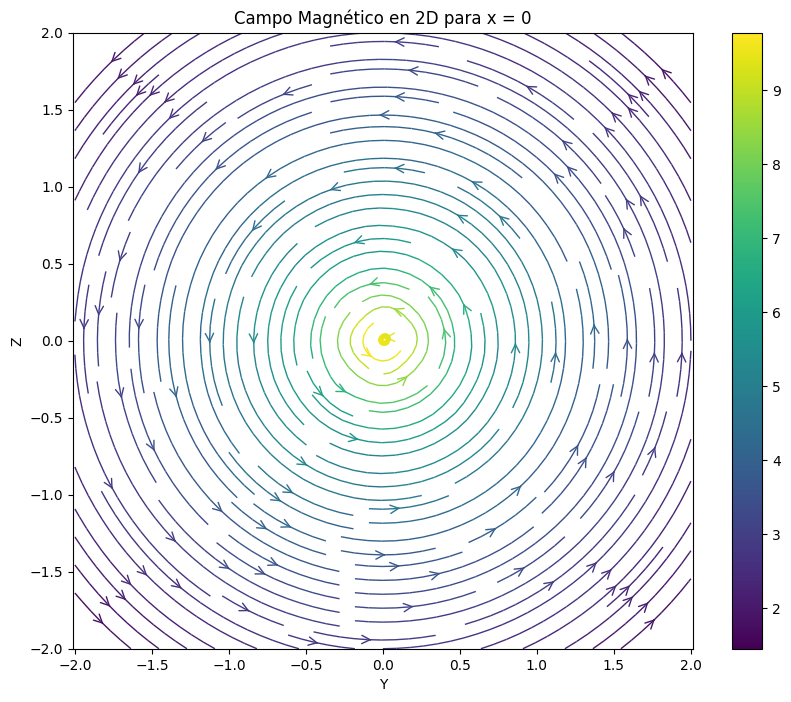

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

x_corte = 0

# Encontramos los índices para los que realizamos el corte
corte_indice = np.where(np.abs(xv - x_corte) < 1)

# Obtenemos los datos para graficar
y_slice_data = yv[corte_indice]
z_slice_data = zv[corte_indice]
By_slice_data = By[corte_indice]
Bz_slice_data = Bz[corte_indice]

# Inicializamos la grilla
y_grid = np.linspace(-2, 2, 20)
z_grid = np.linspace(-2, 2, 20)
Y_grid, Z_grid = np.meshgrid(y_grid, z_grid)

# Interpolate the vector components
By_grid = griddata((y_slice_data, z_slice_data), By_slice_data, (Y_grid, Z_grid), method='linear')
Bz_grid = griddata((y_slice_data, z_slice_data), Bz_slice_data, (Y_grid, Z_grid), method='linear')

# Create 2D plot with streamplot
plt.figure(figsize=(10,8))
color = 2 * np.log(np.hypot(By_grid, Bz_grid))
plt.streamplot(y_grid, z_grid, By_grid, Bz_grid, color=color, linewidth=1, cmap='viridis',
          density=1.5, arrowstyle='->', arrowsize=1.5)
plt.title(f'Campo Magnético en 2D para x = {x_corte}')
plt.xlabel('Y')
plt.ylabel('Z')
plt.colorbar()
plt.axis('equal')
plt.show()